CS156 Final Project

TEMPERATURE DATA TAKEN FROM: https://www.ncdc.noaa.gov/orders/isd/8438857509990dat.txt
Data included: Temperature, hour, and date for Juneau, Alaska from May 2009 to January 2017
Goal: Train a model using Gaussian Processes
to predict temperature in Juneau, Alaska, using hour and day of year (effectively hour of year).
To account for daily variations in temperature, I  use a 2D input (hour,day).
Ideally, comparing results from this to a periodic kernel could have been more optimal.
However, the kernel would not run on my machine. I kept the periodic kernel commented for future potential use.
I train the model on data from May 2009 to December 2015, then test my model with January 2016 to December 2017.

In [1]:
import copy
import GPy
from GPy.models import SparseGPRegression
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('alaskatemp.csv')
df = df[df['temp'] != '****']
df = df[df['temp'] != np.inf]
df = df[df['temp'] != '****']   #removes bad data
df = df[df['slp'] != '******']
df['dtim'] = pd.to_datetime(df['time'],format=('%Y%m%d%H%M'))
df['dayofyear'] = df['dtim'].dt.strftime('%j').astype(int)
df['HR'] = df['dtim'].dt.strftime('%H').astype(int)
df['TMP'] = df['temp'].astype(int)
df['year'] = df['dtim'].dt.strftime('%Y').astype(int)
df['month'] = df['dtim'].dt.strftime('%m').astype(int)

df.head()


,time,temp,slp,dtim,dayofyear,HR,TMP,year,month
0,200905071600,44,1017.7,2009-05-07 16:00:00,127,16,44,2009,5
1,200905071700,44,1017.8,2009-05-07 17:00:00,127,17,44,2009,5
2,200905071800,44,1018.7,2009-05-07 18:00:00,127,18,44,2009,5
3,200905071900,45,1019.3,2009-05-07 19:00:00,127,19,45,2009,5
4,200905072000,45,1019.9,2009-05-07 20:00:00,127,20,45,2009,5


In [2]:
## TRAIN TEST SPLIT

train_data = df[df['year'].isin(['2009','2010','2011','2012','2013','2014','2015'])]
test_data = df[df['year'].isin(['2016','2017'])]

train_data = train_data.values #converts pandas dataframe to a numpy ndarray
test_data = test_data.values   #converts pandas dataframe to a numpy ndarray

train_hours = np.array(train_data[:,5],dtype=float).reshape(-1,1)
test_hours = np.array(test_data[:,5],dtype=float).reshape(-1,1)

train_days = np.array(train_data[:,4], dtype=float).reshape(-1,1)
test_days = np.array(test_data[:,4], dtype=float).reshape(-1,1)

train_temperatures = np.array(train_data[:,6])
test_temperatures = np.array(test_data[:,6])

x_train = np.array(train_hours+train_days*24-24).reshape(-1,1)
x_test = np.array(test_hours+test_days*24-24).reshape(-1,1)

y_train = train_temperatures.reshape(-1,1)
y_test = test_temperatures.reshape(-1,1)

x_train_2d = np.concatenate((train_hours,train_days),axis=1)
x_test_2d = np.concatenate((test_hours,test_days),axis=1)


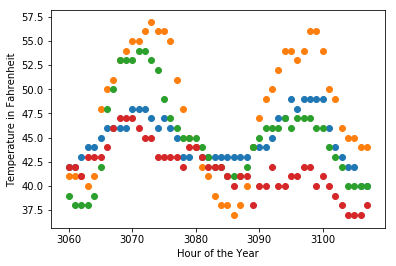

In [3]:
#WHAT TWO DAYS OF TEMPERATURE DATA LOOKS LIKE over four years (on same day)

start = 20 #starting hour of the year
nextyear=start+8690 #that same starting hour the next year
following=nextyear+8573 #and the year after that
fourth=following+8503 #and the next year after that

plt.scatter(x_train[start:start+48],y_train[start:start+48])
plt.scatter(x_train[nextyear:nextyear+48],y_train[nextyear:nextyear+48])
plt.scatter(x_train[following:following+48],y_train[following:following+48])
plt.scatter(x_train[fourth:fourth+48],y_train[fourth:fourth+48])
plt.ylabel('Temperature in Fahrenheit')
plt.xlabel('Hour of the Year')
plt.show()

In [4]:
#Function for periodic kernel to be implemented in GPy:

p=24.0 #period
lscale=1000.0 #lengthscale
var=5.0 #output variance

def K(X,X2):
    if X2 is None: X2 = X
    M=[]
    for i in range(len(X)):
        difference = (X[i]-X2[i])
        absdif = abs(difference)
        insin = np.pi*absdif/p
        numerator = -2*(np.sin(insin[0]))
        denominator = (lscale**2)
        firstterm = np.exp(float(numerator)/float(denominator))
        numerator2 = -(difference**2)[0]
        denominator2 = 2*denominator
        secondterm = np.exp(float(numerator2)/float(denominator2))
        kern=var*firstterm*secondterm
        M.append(kern)
    return np.array(M)

periodic_kernel_output = K(x_train,y_train)

In [5]:
# This is a Custom Periodic Kernel class implementation.
# It runs with errors. To be used in other machine in future.

from GPy.kern.src.kern import Kern
from GPy.core.parameterization.param import Param
import numpy as np
from GPy.kern import RatQuad

class RatQuad(Kern):
    
    def __init__(self,input_dim,variance=1.,lengthscale=1.,power=1.,active_dims=None):
        super(RatQuad, self).__init__(input_dim, active_dims, 'rat_quad')        
        assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance = Param('variance', variance)
        self.lengthscale = Param('lengthscale', lengthscale)
        self.power = Param('power', power)
        self.add_parameters(self.variance, self.lengthscale, self.power)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        M=[]
        for i in range(len(X)):
            difference = (X[0]-X2[0])
            absdif = abs(difference)
            insin = np.pi*absdif/p
            numerator = -2*(np.sin(insin[0]))
            denominator = (lscale**2)[0]
            firstterm = np.exp(float(numerator)/float(denominator))
            numerator2 = -(difference**2)[0]
            denominator2 = 2*denominator
            secondterm = np.exp(float(numerator2)/float(denominator2))
            kern=nv*firstterm*secondterm
            M.append(kern)
        return np.array(M)    

#mykern = RatQuad(1)
#mykern.K(x_train,y_train)

In [6]:
from sklearn.gaussian_process.kernels import ExpSineSquared
from GPy.kern.src.periodic import Periodic

np.random.seed(101)
ndim=2
sigma = 1e-2
noise_var = 4.0
p=24
nv = noise_var
lscale = np.array([24])

#Several kernel options below. Used basic RBF with average performace.

#Future iteration should include GridSearchCross-Validation.

k1 = GPy.kern.RBF(ndim, lengthscale=2.,variance = 1.0)
k2 = GPy.kern.src.periodic.Periodic(input_dim=1,variance=2.0,lengthscale=lscale,
                                    period=23.0,n_freq=365.0,lower=None,upper=None,
                                    active_dims=1,name=None)
k3 = ExpSineSquared(24,365, length_scale_bounds = (22.0,26.0),
                    periodicity_bounds=(1e-05, 100000.0))
k4 = Periodic(input_dim=1,variance=2.0,lengthscale=6,period=24,n_freq=366,
              lower=None,upper=None,active_dims=1,name=None)
k5=K



Name : sparse_gp
Objective : 11201647.9545
Number of Parameters : 103
Number of Optimization Parameters : 103
Updates : True
Parameters:
  sparse_gp.               |    value  |  constraints  |  priors
  inducing_inputs          |  (50, 2)  |               |        
  rbf.variance             |      1.0  |      +ve      |        
  rbf.lengthscale          |      2.0  |      +ve      |        
  Gaussian_noise.variance  |      4.0  |      +ve      |        


 /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


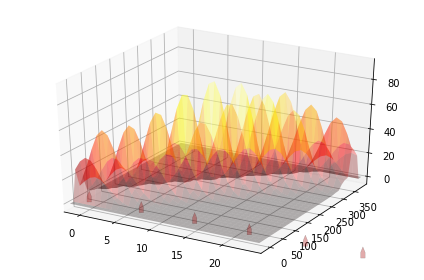

In [7]:
#sparse GP:
n_inducing = 50
inducing = [((np.linspace(0.0,24.0,n_inducing)[i],
              np.linspace(0.0,366.0,n_inducing)[i])) for i in range(n_inducing)]
inducing= np.asarray((inducing))

m = GPy.models.SparseGPRegression(x_train_2d,y_train,Z=inducing,kernel=k1)
m.likelihood.variance = noise_var
m.plot(plot_data=False, projection="3d",legend=False)
print m



Name : sparse_gp
Objective : 183235.670245
Number of Parameters : 103
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |          value  |  constraints  |  priors
  inducing_inputs          |        (50, 2)  |     fixed     |        
  rbf.variance             |  25.3629187912  |      +ve      |        
  rbf.lengthscale          |  95.6158062397  |      +ve      |        
  Gaussian_noise.variance  |   37.027537674  |      +ve      |        


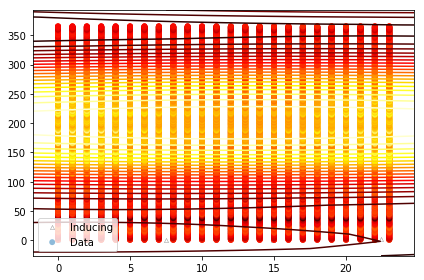

In [8]:
# with Optimized Covariance Parameters
m.inducing_inputs.fix()
m.optimize('bfgs')
m.plot()
print m

MSE is: 37.3966769652


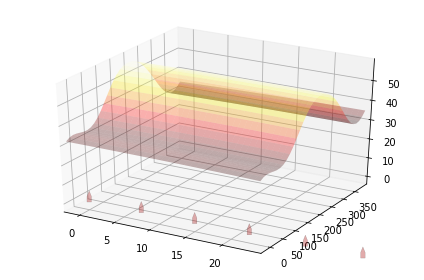

In [9]:
#Hard cutoffs in plot suggest that periodicity of daily variations isn't represented.

#I use mean squared error to measure performance of the model on test set:
predict = m.predict(x_test_2d)
m.plot(plot_data=False, projection="3d",legend=False)

from sklearn.metrics import mean_squared_error as mse
mse = mse(y_test,predict[0])
print 'MSE is:', mse
